In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()
        self.actions_all = list((i, j) for i in range(self.n_rows) for j in range(self.n_cols))

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

#**Часть вторая: добавим нейронных сетей**

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class Network(nn.Module):
    def __init__(self, n_rows, n_cols, n_hidden_size = 50):
        nn.Module.__init__(self)
        n = n_rows * n_cols
        self.conv1 = nn.Conv2d(2, n_hidden_size, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_hidden_size, n_hidden_size, kernel_size = 3, padding = 1)
        self.l1 = nn.Linear(n * n_hidden_size, n)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.l1(torch.flatten(x, start_dim=1)))
        return x

In [8]:
class TicTacToe_DQN():
    def __init__(self, env, memory_size, model):
        self.env = env
        self.memory_crosses = ReplayMemory(memory_size)
        self.memory_noughts = ReplayMemory(memory_size)
        self.model_crosses = model
        self.model_noughts = model
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), 0.0001)
        self.optimizer_noughts = optim.Adam(self.model_noughts.parameters(), 0.0001)
        self.episode_durations = []
        
        self.gamma = 0.8
        self.batch_size = 128

        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2000
        self.num_step = 0

    def select_greedy_action(self, state, model):
        return model(state).data.max(1)[1].view(1, 1)

    def convert_action_index(self, action):
        return list((i, j) for i in range(self.env.n_rows) for j in range(self.env.n_cols))[action]

    def select_action(self, state, model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, model)

        else:
            action_space = self.env.getEmptySpaces()
            action = action_space[np.random.randint(0, len(action_space))]
            return torch.tensor([[self.env.n_cols * action[0] + action[1]]], dtype=torch.int64)

    def board_to_tensor(self, board):
        crosses = torch.FloatTensor(board == 1)
        naughts = torch.FloatTensor(board == -1)
        m = torch.unsqueeze(torch.stack((crosses, naughts)),0)
        return m

    def run_one_episode(self, memory, model, crosses = False, greedy=False):
        state_tensor = self.board_to_tensor(self.env.board)
        done = False
        while not done:
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor, model)
                else:
                    action = self.select_action(state_tensor, model)
            (next_state_hash, empty_spaces, curturn), reward, done, _ = self.env.step(self.convert_action_index(action.numpy()[0][0]))
            if (not crosses) & (int(abs(reward)) == 1):
                reward *= -1

            if done:
                next_state_tensor = self.board_to_tensor(self.env.board)
                transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                memory.store(transition)
                break
            partner_action = tuple(empty_spaces[np.random.randint(0, len(empty_spaces))])
            (next_state_hash, _, _), reward, done, _ = self.env.step(partner_action)
            next_state_tensor = self.board_to_tensor(self.env.board)
            if (not crosses) & (int(abs(reward)) == 1):
                reward *= -1
            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            memory.store(transition)
            state_tensor = next_state_tensor

    def run_episodes(self, do_learning=True, greedy=False):
        self.env.reset()
        self.run_one_episode(self.memory_crosses, self.model_crosses, crosses = True, greedy=greedy)

        self.env.reset()
        action_space = self.env.getEmptySpaces()
        cross_action = tuple(action_space[np.random.randint(0, len(action_space))])
        nought_state = self.env.step(cross_action)[0][0] 
        self.run_one_episode(self.memory_noughts, self.model_noughts, crosses = False, greedy=greedy)

        if do_learning:
            self.learn()


    def learn_one_batch(self, model, memory, optimizer):
        if len(memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def learn(self):
        self.learn_one_batch(self.model_crosses, self.memory_crosses, self.optimizer_crosses)
        self.learn_one_batch(self.model_noughts, self.memory_noughts, self.optimizer_noughts)

In [11]:
def test_dqn(dqn):
    games_number = 500      
    results = []
    for player in ['crosses', 'noughts']:
        env = dqn.env
        result = 0
        result_excluding10 = 0
        good_games = 0
        for _ in range(games_number):
            env.reset()
            done = False
            while not done:
                action_space = env.getEmptySpaces()
                if player == 'crosses':
                    state_tensor = dqn.board_to_tensor(dqn.env.board)
                    model = dqn.model_crosses
                    with torch.no_grad():
                        action_crosses = dqn.convert_action_index(dqn.select_greedy_action(state_tensor, model).numpy()[0][0])
                else:
                    action_crosses = tuple(action_space[np.random.randint(0, len(action_space))])

                _, reward, done, _ = env.step(action_crosses)
                if not done:
                    action_space = env.getEmptySpaces()
                    if player == 'noughts':
                        state_tensor = dqn.board_to_tensor(dqn.env.board)
                        model = dqn.model_noughts
                        with torch.no_grad():
                            action_noughts = dqn.convert_action_index(dqn.select_greedy_action(state_tensor, model).numpy()[0][0])
                    else:
                        action_noughts = tuple(action_space[np.random.randint(0, len(action_space))])
                    _, reward, done, _ = env.step(action_noughts)
            if (player == 'noughts') & (reward != -10):
                reward *= -1
            result += reward
            if reward != -10:
                result_excluding10 += reward
                good_games += 1
        results.append(result / games_number)
        if good_games == 0:
            results.append(result_excluding10 / 1)
        else:
            results.append(result_excluding10 / good_games)
    return results

def train_dqn(model, loops, games_by_loop):
    crosses_rewards = []
    noughts_rewards = []
    crosses_rewards_exluding10 = []
    noughts_rewards_exluding10 = []
    for _ in tqdm(range(loops)):
        for _ in range(games_by_loop):
            dqn.run_episodes(do_learning=True)
        crosses_reward, crosses_reward_excluding10, noughts_reward, noughts_reward_excluding10 = test_dqn(dqn)
        crosses_rewards.append(crosses_reward)
        crosses_rewards_exluding10.append(crosses_reward_excluding10)
        noughts_rewards.append(noughts_reward)
        noughts_rewards_exluding10.append(noughts_reward_excluding10)

    indices = range(0, games_by_loop * loops+1, games_by_loop )[1:]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Playing with random agent')
    ax1.plot(indices, crosses_rewards, label='Crosses')
    ax1.plot(indices, noughts_rewards, label='Noughts')
    ax2.plot(indices, crosses_rewards_exluding10, label='Crosses')
    ax2.plot(indices, noughts_rewards_exluding10, label='Noughts')
    ax1.set_title('Average reward')
    ax2.set_title('Average reward (excluding -10)')
    ax1.legend(loc='lower left')
    ax2.legend(loc='lower left')
    ax1.set(xlabel='number of games', ylabel='average reward')
    ax2.set(xlabel='number of games', ylabel='average reward')
    return model

100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


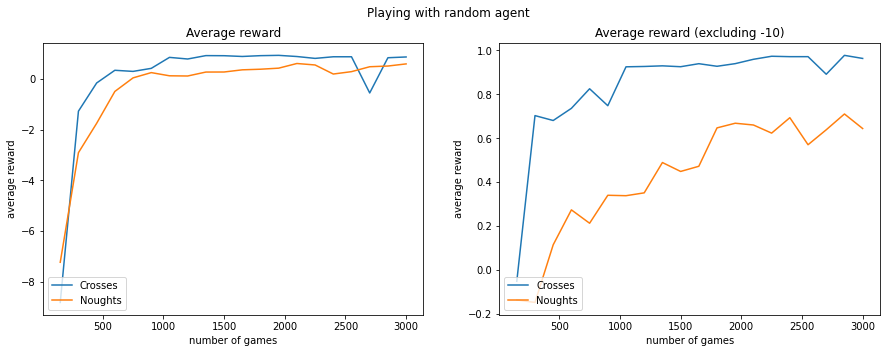

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn = TicTacToe_DQN(env, 10000, Network(N_ROWS,N_COLS)) 
dqn = train_dqn(dqn, loops=20, games_by_loop=150)

100%|██████████| 20/20 [02:35<00:00,  7.76s/it]


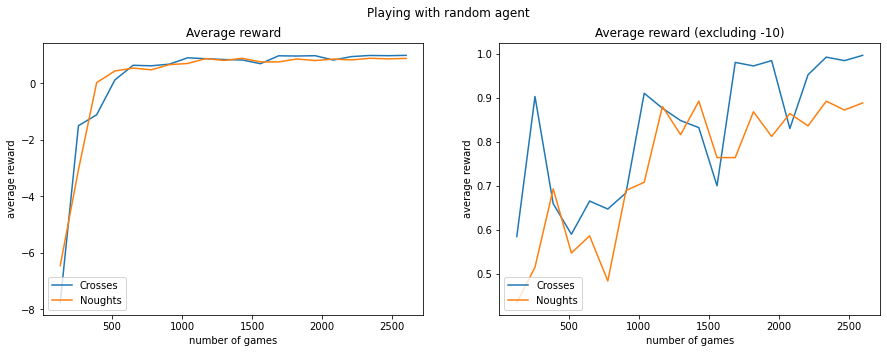

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn = TicTacToe_DQN(env, 10000, Network(N_ROWS,N_COLS)) 
dqn = train_dqn(dqn, loops=20, games_by_loop=130)

100%|██████████| 15/15 [02:57<00:00, 11.86s/it]


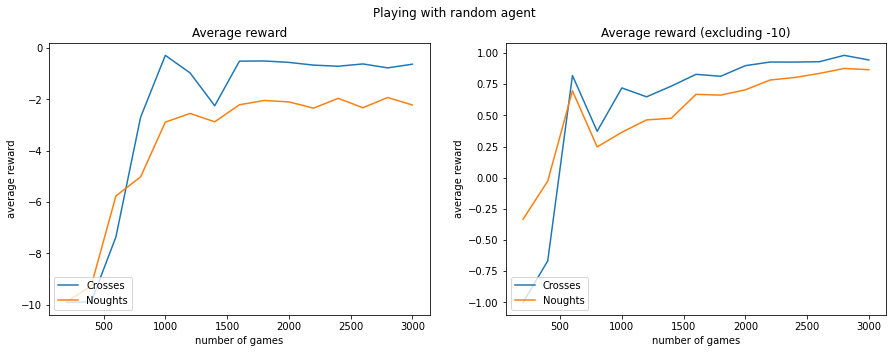

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn = TicTacToe_DQN(env, 10000, Network(N_ROWS,N_COLS)) 
dqn = train_dqn(dqn, loops=15, games_by_loop=200)

100%|██████████| 15/15 [05:33<00:00, 22.26s/it]


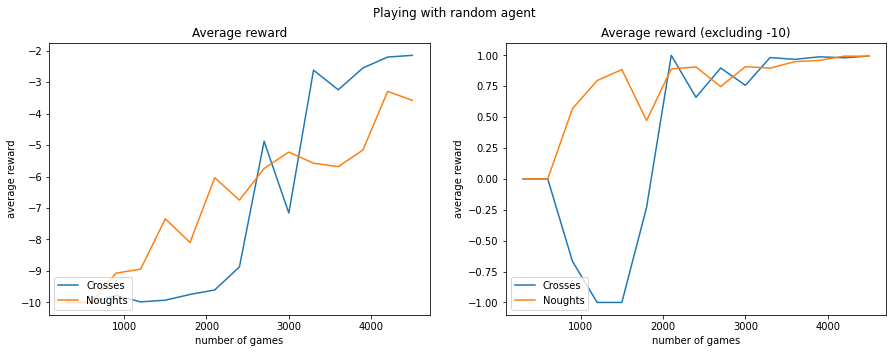

In [ ]:
N_ROWS, N_COLS, N_WIN = 5, 5, 5
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
dqn = TicTacToe_DQN(env, 10000, Network(N_ROWS,N_COLS)) 
dqn = train_dqn(dqn, loops=15, games_by_loop=300)

Если мы хотим обучить модель для N_WIN>4, то хорошо бы модель сделать более глубой, сделать больше сверточных слоёв в ней, чтобы она лучше находила закономерности